# 📥 Importação das Bibliotecas Necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# 📂 Leitura dos Dados

In [2]:
# Função para converter valores com vírgulas para float
def parse_float(val):
    return float(val.replace('.', '').replace(',', '.'))

# Importar e limpar os datasets
# Taxa de Juros - Selic
selic_df = pd.read_csv("Taxa de juros - Selic.csv", sep=";", parse_dates=["data"], dayfirst=True)
selic_df.rename(columns={"data": "Data", "valor": "Selic"}, inplace=True)
selic_df["Selic"] = selic_df["Selic"].apply(parse_float)

# Investimentos Diretos no Exterior (IDE - saídas)
ide_df = pd.read_csv("Investimentos diretos no exterior - IDE - saídas.csv", sep=";", parse_dates=["data"], dayfirst=True)
ide_df.rename(columns={"data": "Data", "valor": "IDE"}, inplace=True)
ide_df["IDE"] = ide_df["IDE"].apply(parse_float)

# Produto Interno Bruto (PIB) em R$ correntes
# Leitura do dataset de PIB
pib_df = pd.read_csv("Produto interno bruto em R$ correntes.csv", sep=";", parse_dates=["data"], dayfirst=True)

# Renomear colunas
pib_df.rename(columns={"data": "Data", "valor": "PIB"}, inplace=True)

# Corrigir o separador decimal (substituir vírgulas por pontos)
pib_df["PIB"] = pib_df["PIB"].str.replace(",", ".", regex=False)

# Tentar converter para numérico
pib_df["PIB"] = pd.to_numeric(pib_df["PIB"], errors='coerce')


# Preencher valores ausentes (opcional: interpolação ou imputação fixa)
pib_df["PIB"].interpolate(method="linear", inplace=True)

# Cotação USD/BRL
usd_brl_df = pd.read_csv("USD_BRL Dados Históricos.csv", sep=",", parse_dates=["Data"], dayfirst=True)
usd_brl_df.rename(columns={"Último": "Cotacao_Dolar"}, inplace=True)
usd_brl_df["Cotacao_Dolar"] = usd_brl_df["Cotacao_Dolar"].apply(parse_float)

C:\Users\elias\AppData\Local\Temp\ipykernel_56464\331531625.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pib_df["PIB"].interpolate(method="linear", inplace=True)


# 🔗 Mesclando os Dados

In [3]:
# Combinar os datasets
# Garantir que os dados tenham a mesma frequência temporal (diária) usando merge
merged_df = usd_brl_df.merge(selic_df, on="Data", how="outer")
merged_df = merged_df.merge(ide_df, on="Data", how="outer")
merged_df = merged_df.merge(pib_df, on="Data", how="outer")

# 🗓️ Preparação dos Dados para Interpolação e Limpeza Final

In [4]:
# Garantir que 'Data' seja o índice e com o tipo datetime
merged_df['Data'] = pd.to_datetime(merged_df['Data'])
merged_df.set_index('Data', inplace=True)

# Preencher dados ausentes com interpolação (agora que a Data é o índice)
merged_df.interpolate(method="time", inplace=True)

# Remover ou preencher valores ausentes (caso ainda haja valores ausentes)
merged_df.dropna(subset=["Selic", "IDE", "PIB", "Cotacao_Dolar"], inplace=True)


C:\Users\elias\AppData\Local\Temp\ipykernel_56464\2096180233.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method="time", inplace=True)


# 📊 Preparação dos Dados para o Modelo

In [5]:
# Criar variáveis de entrada (X) e saída (y)
X = merged_df[["Selic", "IDE", "PIB"]]
y = merged_df["Cotacao_Dolar"]

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🧑‍💻 Divisão dos Dados em Treinamento e Teste

In [6]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🏫 Treinamento do Modelo

In [7]:
# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# 🔮 Fazendo Previsões e Avaliando o Modelo

In [8]:
# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.31197912476530626
RMSE: 0.3996181903806922


# 📉 Visualizando os Resultados

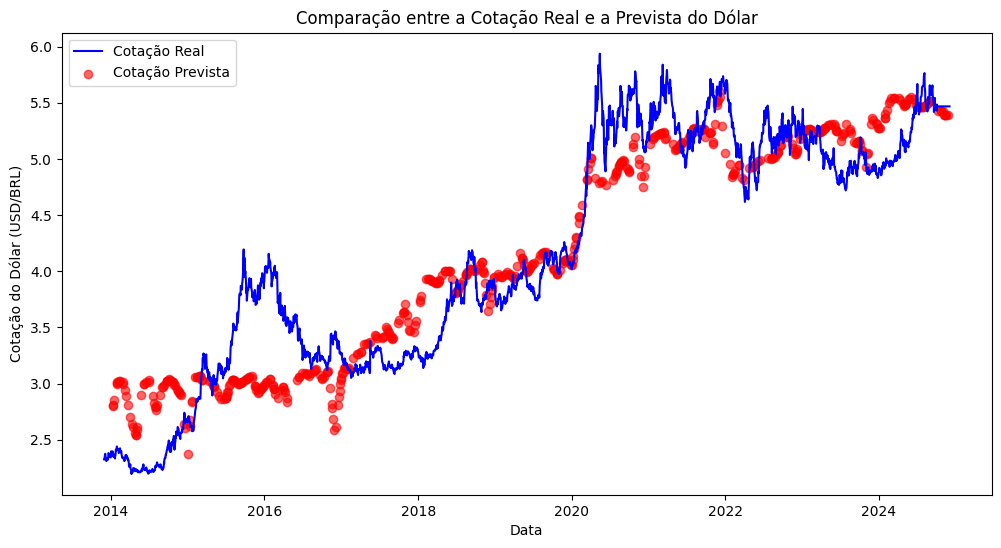

In [9]:
# Criar uma coluna de índice para visualização
merged_df['Index'] = merged_df.index

# Visualizar os resultados
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df["Cotacao_Dolar"], label="Cotação Real", color="blue")

# Usar a coluna de índice para corresponder à posição do teste
plt.scatter(merged_df.loc[y_test.index, 'Index'], y_pred, label="Cotação Prevista", color="red", alpha=0.6)

plt.xlabel("Data")
plt.ylabel("Cotação do Dólar (USD/BRL)")
plt.title("Comparação entre a Cotação Real e a Prevista do Dólar")
plt.legend()
plt.show()